In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

In [ ]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
dataset_path = Path('/content/drive/MyDrive/ColabNotebooks/Dataset-Splitted')
# define the transform
train_transform = transforms.Compose([
    #transforms.Grayscale(1),
    transforms.Resize((256, 256)),  # resize images to 256x256
    transforms.RandomCrop((224, 224)),  # random crop images to 224x224
    transforms.ToTensor(),  # convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize images to ImageNet mean and sd
   # transforms.Normalize(mean=[0.5, ], std=[0.5, ])
])

test_transform = transforms.Compose([
    #transforms.Grayscale(1),
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor(),  # convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize images to ImageNet mean and sd
    #transforms.Normalize(mean=[0.5, ], std=[0.5, ])
])

# define the datasets
#train_dev_sets = torch.utils.data.ConcatDataset([datasets.ImageFolder(dataset_path / 'train'), datasets.ImageFolder(dataset_path / 'val')])
train_dataset = datasets.ImageFolder(dataset_path / 'train', transform=test_transform)

val_dataset = datasets.ImageFolder(dataset_path / 'val', transform=test_transform)
#train_dataset=datasets.ImageFolder(train_dev_sets, transform=train_transform)
test_dataset = datasets.ImageFolder(dataset_path / 'test', transform=test_transform)

# define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_CF = torch.utils.data.DataLoader(test_dataset+train_dataset+val_dataset, batch_size=64, shuffle=False)

In [ ]:
train_dataset.classes[:10]

['benign', 'malignant', 'normal']

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 85.3MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
import torch.nn as nn
from torch.utils.data import ConcatDataset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
# Instantiate the CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

dataset = ConcatDataset([train_dataset])

num_epochs=20
batch_size=128
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [ ]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

# def valid_epoch(model,device,dataloader,loss_fn):
#     valid_loss, val_correct = 0.0, 0
#     model.eval()
#     with torch.no_grad():
#       for images, labels in dataloader:

#           images,labels = images.to(device),labels.to(device)
#           output = model(images)
#           loss=loss_fn(output,labels)
#           valid_loss+=loss.item()*images.size(0)
#           scores, predictions = torch.max(output.data,1)
#           val_correct+=(predictions == labels).sum().item()

#     return valid_loss,val_correct
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    y_true=[]
    y_pred=[]
    with torch.no_grad():
      for images, labels in dataloader:

          images,labels = images.to(device),labels.to(device)
          output = model(images)
          loss=loss_fn(output,labels)
          valid_loss+=loss.item()*images.size(0)
          scores, predictions = torch.max(output.data,1)
          val_correct+=(predictions == labels).sum().item()
         # _,predicted_only=torch.max(output,1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predictions.cpu().numpy())

    return valid_loss,val_correct, y_true, y_pred

In [ ]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
num_classes=3
label_names=["Benign","Malignant","Normal"]
# Initialize an empty confusion matrix
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    y_test=[]
    y_pred=[]

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    #model = ConvNet()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct,y_test,y_pred=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)


Fold 1
Epoch:1/20 AVG Training Loss:6.839 AVG Test Loss:14.074 AVG Training Acc 23.81 % AVG Test Acc 25.53 %
Epoch:2/20 AVG Training Loss:1.590 AVG Test Loss:10.693 AVG Training Acc 79.29 % AVG Test Acc 17.02 %
Epoch:3/20 AVG Training Loss:0.715 AVG Test Loss:3.365 AVG Training Acc 83.57 % AVG Test Acc 48.94 %
Epoch:4/20 AVG Training Loss:0.190 AVG Test Loss:1.420 AVG Training Acc 93.57 % AVG Test Acc 68.09 %
Epoch:5/20 AVG Training Loss:0.092 AVG Test Loss:0.770 AVG Training Acc 97.38 % AVG Test Acc 74.47 %
Epoch:6/20 AVG Training Loss:0.061 AVG Test Loss:0.392 AVG Training Acc 98.81 % AVG Test Acc 87.23 %
Epoch:7/20 AVG Training Loss:0.040 AVG Test Loss:0.361 AVG Training Acc 98.10 % AVG Test Acc 87.23 %
Epoch:8/20 AVG Training Loss:0.031 AVG Test Loss:0.336 AVG Training Acc 99.29 % AVG Test Acc 89.36 %
Epoch:9/20 AVG Training Loss:0.057 AVG Test Loss:0.401 AVG Training Acc 98.33 % AVG Test Acc 85.11 %
Epoch:10/20 AVG Training Loss:0.007 AVG Test Loss:0.469 AVG Training Acc 100.00 % 

In [ ]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['test_acc'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))

Performance of 10 fold cross validation
Average Training Loss: 0.0717 	 Average Test Loss: 0.3977 	 Average Training Acc: 98.713 	 Average Test Acc: 93.426


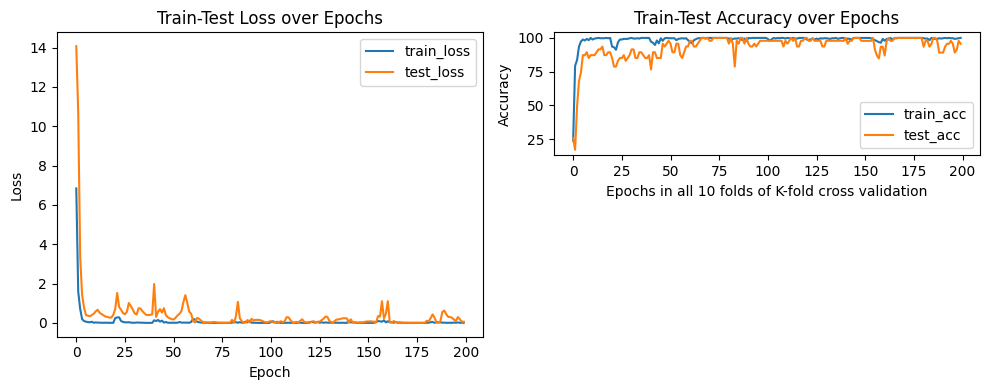

In [ ]:
import matplotlib.pyplot as plt
# Plot training metrics
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.plot(history['test_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train-Test Loss over Epochs")

plt.legend(['train_loss','test_loss'])
plt.subplot(2, 2, 2)
plt.plot((history['train_acc']))
plt.plot((history['test_acc']))
plt.xlabel("Epochs in all 10 folds of K-fold cross validation")
plt.ylabel("Accuracy")
plt.title("Train-Test Accuracy over Epochs")
plt.tight_layout()
plt.legend(['train_acc', 'test_acc'])
plt.show()

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

# Load and preprocess the new image
image_path = "/content/drive/MyDrive/ColabNotebooks/Dataset-Splitted/test/normal/normal (118).png"
image = Image.open(image_path).convert("RGB")

# Define the transformation for the new image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the transformation to the new image
input_image = transform(image).unsqueeze(0)

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions on the new image
with torch.no_grad():
    outputs = model(input_image)

# Get the predicted class labels
_, predicted = outputs.max(1)

# Get the predicted class probabilities
probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]

# Print the predicted class label and probabilities
class_label = predicted.item()
class_prob = probabilities[class_label].item()
print(f"Predicted class: {test_dataset.classes[class_label]}")
print(f"Probability: {class_prob:.2f}")


Predicted class: benign
Probability: 0.67


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
num_classes=3
label_names=["Benign","Malignant","Normal"]
# Initialize an empty confusion matrix
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Inside your training loop
for epoch in range(num_epochs):
    # ... (your existing code)

    # Get predictions for the validation set
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader_CF:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate confusion matrix
conf_matrix += confusion_matrix(y_true, y_pred, labels=range(num_classes))

    # Print or store the confusion matrix if needed
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# from sklearn.metrics import precision_score
# precision_score(y_pred)